In [1]:
import os
import time
import random
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor, Compose, ToPILImage, Resize
from torchvision.transforms.functional import invert
from torchvision.io import read_image
from PIL import Image
from matplotlib import pyplot as plt
from torchsummary import summary

In [2]:
class MembraneDataset(Dataset):
    def __init__(self, dataset_dir, transform=None, target_transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images_dir = os.path.join(self.dataset_dir, 'image')
        self.labels_dir = os.path.join(self.dataset_dir, 'label')
        self.images_paths = [os.path.join(self.images_dir, i) for i in sorted(os.listdir(self.images_dir))]
        self.labels_paths = [os.path.join(self.labels_dir, i) for i in sorted(os.listdir(self.labels_dir))]

    def __len__(self):
        return len(self.labels_paths)

    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx])
        label = Image.open(self.labels_paths[idx])

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [3]:
dataset = MembraneDataset('dataset/test/')

In [4]:
def plot_sample_images(n):
    for i in range(n):
        idx = random.randint(0, dataset.__len__() - 1)
        images = dataset.__getitem__(idx)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.supylabel(f'Sample #{idx + 1}')
        fig.tight_layout()
        
        ax1.imshow(images[0], cmap='gray')
        ax1.set_title('Image')
        ax2.imshow(images[1], cmap='gray')
        ax2.set_title('Label')

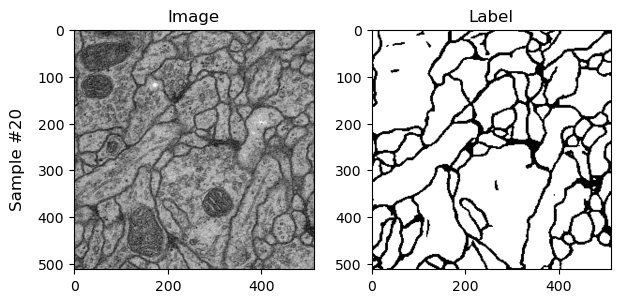

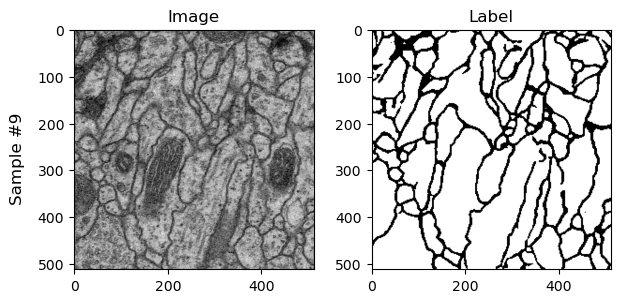

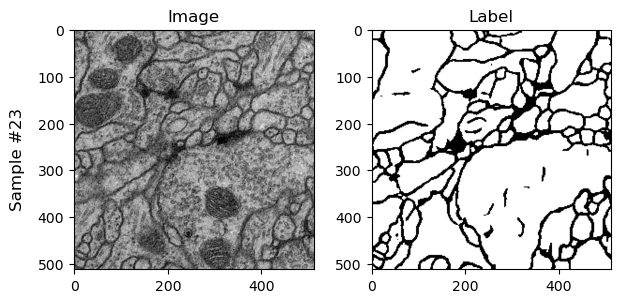

In [5]:
plot_sample_images(3)

In [6]:
class Conv2d3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv2d3x3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )

    def forward(self, x):
        return self.conv(x)

In [7]:
class DoubleConv2d3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d3x3, self).__init__()
        self.double_conv = nn.Sequential(
            Conv2d3x3(in_channels=in_channels, out_channels=out_channels),
            Conv2d3x3(in_channels=out_channels, out_channels=out_channels)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class DoubleConv2d3x3MaxPool2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d3x3MaxPool2d, self).__init__()
        self.double_conv_max_pool = nn.Sequential(
            DoubleConv2d3x3(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        return self.double_conv_max_pool(x)

In [9]:
class DoubleConv2d3x3ConvTranspose2d3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d3x3ConvTranspose2d3x3, self).__init__()
        self.double_conv_transpose = nn.Sequential(
            DoubleConv2d3x3(in_channels=in_channels, out_channels=out_channels),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )

    def forward(self, x):
        return self.double_conv_transpose(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dc_1 = DoubleConv2d3x3(in_channels=1, out_channels=32)               # 32, 512, 512
        self.dcm_1 = DoubleConv2d3x3MaxPool2d(in_channels=32, out_channels=64)    # 64, 256, 256
        self.dcm_2 = DoubleConv2d3x3MaxPool2d(in_channels=64, out_channels=128)   # 128, 128, 128
        self.dcm_3 = DoubleConv2d3x3MaxPool2d(in_channels=128, out_channels=256)  # 256, 64, 64
        self.dcm_4 = DoubleConv2d3x3MaxPool2d(in_channels=256, out_channels=512)  # 512, 32, 32

    def forward(self, x):
        x = self.dc_1(x)
        x = self.dcm_1(x)
        a = x
        x = self.dcm_2(x)
        b = x
        x = self.dcm_3(x)
        c = x
        x = self.dcm_4(x)
        return x, a, b, c

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dc_1 = DoubleConv2d3x3(in_channels=512, out_channels=512)                     # 512, 16, 16
        self.dct_1 = DoubleConv2d3x3ConvTranspose2d3x3(in_channels=512, out_channels=256)  # 256, 32, 32
        self.c1 = Conv2d3x3(in_channels=512, out_channels=256)                             # 256, 32, 32
        self.dct_2 = DoubleConv2d3x3ConvTranspose2d3x3(in_channels=256, out_channels=128)  # 128, 64, 64
        self.c2 = Conv2d3x3(in_channels=256, out_channels=128)                             # 128, 64, 64
        self.dct_3 = DoubleConv2d3x3ConvTranspose2d3x3(in_channels=128, out_channels=64)   # 64, 128, 128
        self.c3 = Conv2d3x3(in_channels=128, out_channels=64)                              # 64, 128, 128
        self.dct_4 = DoubleConv2d3x3ConvTranspose2d3x3(in_channels=64, out_channels=32)    # 32, 256, 256
        self.out = Conv2d3x3(in_channels=32, out_channels=1)                               # 1, 512, 512

    def forward(self, x, a, b, c):
        x = self.dc_1(x)
        x = self.dct_1(x)        
        x = torch.cat((x, c), dim=1)
        x = self.c1(x)
        x = self.dct_2(x)
        x = torch.cat((x, b), dim=1)
        x = self.c2(x)
        x = self.dct_3(x)
        x = torch.cat((x, a), dim=1)
        x = self.c3(x)
        x = self.dct_4(x)
        x = self.out(x)    
        return x

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, image):
        x, a, b, c = self.encoder(image)
        y = self.decoder(x, a, b, c)
        return y

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [14]:
model = Network().to(device)

In [15]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [16]:
model.apply(init_weights)

Network(
  (encoder): Encoder(
    (dc_1): DoubleConv2d3x3(
      (double_conv): Sequential(
        (0): Conv2d3x3(
          (conv): Sequential(
            (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Conv2d3x3(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
    (dcm_1): DoubleConv2d3x3MaxPool2d(
      (double_conv_max_pool): Sequential(
        (0): DoubleConv2d3x3(
          (double_conv): Sequential(
            (0): Conv2d3x3(
              (conv): Sequential(
                (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
         

In [17]:
summary(model, [(1, 512, 512)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
         Conv2d3x3-4         [-1, 32, 512, 512]               0
            Conv2d-5         [-1, 32, 512, 512]           9,248
              ReLU-6         [-1, 32, 512, 512]               0
       BatchNorm2d-7         [-1, 32, 512, 512]              64
         Conv2d3x3-8         [-1, 32, 512, 512]               0
   DoubleConv2d3x3-9         [-1, 32, 512, 512]               0
           Conv2d-10         [-1, 64, 512, 512]          18,496
             ReLU-11         [-1, 64, 512, 512]               0
      BatchNorm2d-12         [-1, 64, 512, 512]             128
        Conv2d3x3-13         [-1, 64, 512, 512]               0
           Conv2d-14         [-1, 64, 5

In [18]:
learning_rate = 1e-3
batch_size = 16
start_epoch = 0
epochs = 100

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
training_data = MembraneDataset('dataset/train/', transform=Compose([ToTensor(), Resize((256, 256))]), target_transform=Compose([ToTensor(), Resize((256, 256))]))
test_data = MembraneDataset('dataset/test/', transform=Compose([ToTensor(), Resize((256, 256))]), target_transform=Compose([ToTensor(), Resize((256, 256))]))

In [21]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [22]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [23]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (a_image, out_image) in enumerate(dataloader):
        a, o = a_image.to(device), out_image.to(device)
        preds = model(a)
        loss = loss_fn(preds, o.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss_fn(preds, o.float()).item()

    train_loss /= num_batches
    print(f"Avg. Train loss: {train_loss:>8f}")

# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    dice_score = 0

    with torch.no_grad():
        for batch, (a_image, out_image) in enumerate(dataloader):
            a, o = a_image.to(device), out_image.to(device)
            pred = model(a)
            test_loss += loss_fn(pred, o.float()).item()
            
    test_loss /= num_batches
    print(f"Avg. Test loss: {test_loss:>8f}")

In [24]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
for t in range(start_epoch, epochs):
    if start_epoch > 0:
        resume_epoch = start_epoch - 1
        resume(model, f"checkpoints/epoch-{resume_epoch}.pth")
    
    t0 = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print(f"Epoch time: {time.time() - t0}\n")
    checkpoint(model, f"checkpoints/epoch-{t}.pth")
print("Done!")

Epoch 1
-------------------------------
Avg. Train loss: 0.766790
Avg. Test loss: 0.575066
Epoch time: 0.8436157703399658

Epoch 2
-------------------------------
Avg. Train loss: 0.691026
Avg. Test loss: 0.671218
Epoch time: 0.7746567726135254

Epoch 3
-------------------------------
Avg. Train loss: 0.669210
Avg. Test loss: 0.902531
Epoch time: 0.7765755653381348

Epoch 4
-------------------------------
Avg. Train loss: 0.648034
Avg. Test loss: 1.050405
Epoch time: 0.7748913764953613

Epoch 5
-------------------------------
Avg. Train loss: 0.627247
Avg. Test loss: 1.302425
Epoch time: 0.7753658294677734

Epoch 6
-------------------------------
Avg. Train loss: 0.609390
Avg. Test loss: 1.570673
Epoch time: 0.7729337215423584

Epoch 7
-------------------------------
Avg. Train loss: 0.596773
Avg. Test loss: 1.537783
Epoch time: 0.7745645046234131

Epoch 8
-------------------------------
Avg. Train loss: 0.586950
Avg. Test loss: 1.861004
Epoch time: 0.7734885215759277

Epoch 9
--------

In [25]:
def infer_and_plot_results(model, n=5):
    subset_indices = [random.randint(0, test_data.__len__() - 1) for i in range(n)]
    data_subset = Subset(test_data, subset_indices)
    data_subset_loader = DataLoader(data_subset, batch_size=1, shuffle=True)
    
    size = len(data_subset_loader.dataset)
    num_batches = len(data_subset_loader)
    model.eval()
    with torch.no_grad():
        for batch, (image, label) in enumerate(data_subset_loader):
            a, l = image.to(device), label.to(device)
            p = model(a)

            a_permu = torch.permute(a[0], (1, 2, 0))
            l_permu = torch.permute(l[0], (1, 2, 0))
            p_permu = torch.permute(p[0], (1, 2, 0))

            a_array = a_permu.cpu().data.numpy().astype(np.float16)
            l_array = l_permu.cpu().data.numpy().astype(np.uint8)
            p_array = (p_permu > 0).cpu().data.numpy().astype(np.uint8)

            image = a_array
            label = l_array
            predi = p_array
            

            fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
            fig.supylabel(f'Test Output')
            fig.tight_layout()
            
            ax1.imshow(image, cmap='gray')
            ax1.set_title('Image')
            ax2.imshow(label, cmap='gray')
            ax2.set_title('Label')
            ax3.imshow(predi, cmap='gray')
            ax3.set_title('Prediction')

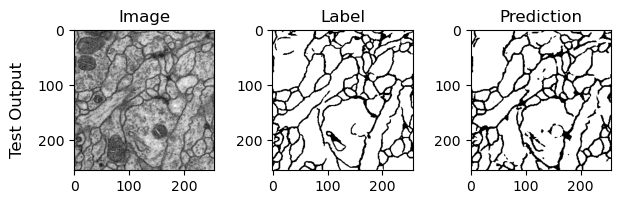

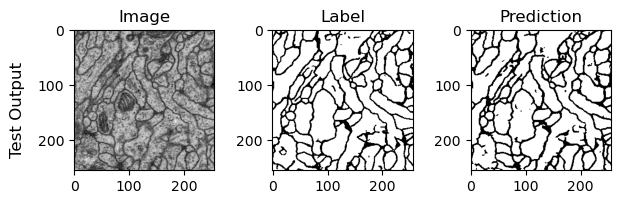

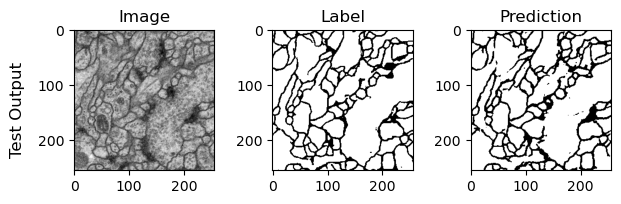

In [26]:
infer_and_plot_results(model, 3)